# Isolation can be more effective in suppressive the epidemic by removing susceptibles

Quad 2.1, 20/03/2020

Idea: open system by removing Susceptibles with isolation and prevention.

Author: Daniele Proverbio  
        LCSB Luxembourg       
        20/03/2020

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd #manipolazione dati

from scipy import stats #statistica
from scipy.optimize import curve_fit

In [149]:
def base_seir_model(init_vals, params, t):
    S_0, E_0, I_0, R_0 = init_vals
    
    S, E, I, R= [S_0], [E_0], [I_0], [R_0]
    alpha, beta, gamma = params
    dt = t[1] - t[0]
    for _ in t[1:]:
        next_S = S[-1] - (beta*S[-1]*I[-1])*dt
        next_E = E[-1] + (beta*S[-1]*I[-1] - alpha*E[-1])*dt
        next_I = I[-1] + (alpha*E[-1] - gamma*I[-1])*dt
        next_R = R[-1] + (gamma*I[-1])*dt
        
        S.append(next_S)
        E.append(next_E)
        I.append(next_I)
        R.append(next_R)
    return np.stack([S, E, I, R]).T

def removal_seir_model(init_vals, params, t):
    S_0, E_0, I_0, R_0, P_0 = init_vals
    S, E, I, R, P = [S_0], [E_0], [I_0], [R_0], [P_0]
    alpha, beta, gamma, mu = params
    dt = t[1] - t[0]
    for _ in t[1:]:
        next_S = S[-1] - (beta*S[-1]*I[-1] + mu*S[-1])*dt
        next_E = E[-1] + (beta*S[-1]*I[-1] - alpha*E[-1])*dt
        next_I = I[-1] + (alpha*E[-1] - gamma*I[-1])*dt
        next_R = R[-1] + (gamma*I[-1])*dt
        next_P = P[-1] + (mu*S[-1])*dt
        S.append(next_S)
        E.append(next_E)
        I.append(next_I)
        R.append(next_R)
        P.append(next_P)
    return np.stack([S, E, I, R, P]).T


def removal_and_social_distancing_seir_model(init_vals, params, t):
    S_0, E_0, I_0, R_0, P_0 = init_vals
    S, E, I, R, P = [S_0], [E_0], [I_0], [R_0], [P_0]
    alpha, beta, gamma, mu, rho = params
    dt = t[1] - t[0]
    for _ in t[1:]:
        next_S = S[-1] - (rho*beta*S[-1]*I[-1] + mu*S[-1])*dt
        next_E = E[-1] + (rho*beta*S[-1]*I[-1] - alpha*E[-1])*dt
        next_I = I[-1] + (alpha*E[-1] - gamma*I[-1])*dt
        next_R = R[-1] + (gamma*I[-1])*dt
        next_P = P[-1] + (mu*S[-1])*dt
        S.append(next_S)
        E.append(next_E)
        I.append(next_I)
        R.append(next_R)
        P.append(next_P)
    return np.stack([S, E, I, R, P]).T


def seir_model_with_soc_dist(init_vals, params, t):
    S_0, E_0, I_0, R_0, tot_inf_0 = init_vals
    S, E, I, R, tot_inf = [S_0], [E_0], [I_0], [R_0], [tot_inf_0]
    alpha, beta, gamma, rho1, rho2 = params
    dt = t[1] - t[0]
    for _ in t[1:]:
        if len(S)<200:
            next_S = S[-1] - (rho1*beta*S[-1]*I[-1])*dt
            next_E = E[-1] + (rho1*beta*S[-1]*I[-1] - alpha*E[-1])*dt
        else: 
            next_S = S[-1] - (rho2*beta*S[-1]*I[-1])*dt
            next_E = E[-1] + (rho2*beta*S[-1]*I[-1] - alpha*E[-1])*dt
            
        next_I = I[-1] + (alpha*E[-1] - gamma*I[-1])*dt
        next_R = R[-1] + (gamma*I[-1])*dt
        tot_inf_next = tot_inf[-1] + I[-1]*dt 
        S.append(next_S)
        E.append(next_E)
        I.append(next_I)
        R.append(next_R)
        tot_inf.append(tot_inf_next)
    return np.stack([S, E, I, R, tot_inf]).T

def seir_model_with_soc_dist1(init_vals, params, t):
    S_0, E_0, I_0, R_0, tot_inf_0 = init_vals
    S, E, I, R, tot_inf = [S_0], [E_0], [I_0], [R_0], [tot_inf_0]
    alpha, beta, gamma, rho1, rho2 = params
    dt = t[1] - t[0]
    for _ in t[1:]:
        if len(S)<250:
            next_S = S[-1] - (rho1*beta*S[-1]*I[-1])*dt
            next_E = E[-1] + (rho1*beta*S[-1]*I[-1] - alpha*E[-1])*dt
        else: 
            next_S = S[-1] - (rho2*beta*S[-1]*I[-1])*dt
            next_E = E[-1] + (rho2*beta*S[-1]*I[-1] - alpha*E[-1])*dt
            
        next_I = I[-1] + (alpha*E[-1] - gamma*I[-1])*dt
        next_R = R[-1] + (gamma*I[-1])*dt
        tot_inf_next = tot_inf[-1] + I[-1]*dt 
        S.append(next_S)
        E.append(next_E)
        I.append(next_I)
        R.append(next_R)
        tot_inf.append(tot_inf_next)
    return np.stack([S, E, I, R, tot_inf]).T

In [150]:
# Define parameters
t_max = 200
dt = .1
t = np.linspace(0, t_max, int(t_max/dt) + 1)

N = 10000
init_vals = 1 - 1/N, 1/N, 0, 0, 0 ,0    #working with fractions of population
alpha = 0.2    # incubation period 5 days
beta = 1.2    # average contact rate [beta = R0*gamma; R0 = 3.5 (Hellewell, 2020); R0 = 3 from GEI]
gamma = 0.33   # mean infectious period = 3 following German Epidemiology Institute (GEI) [or = 2 (Peng, 2020) in Wuhan]
rho = [0.8, 0.5, 0.35]   # social distancing (to control contact rate )
mu = 0.01     # removal rate
mu1 = 0.02
mu2 = 0.03

params = alpha, beta, gamma
params_soc_dist = alpha, beta, gamma, rho[0], rho[0]
params_soc_dist_2 = alpha, beta, gamma, rho[1], rho[1]
params_soc_dist_3 = alpha, beta, gamma, rho[2], rho[2]
params_soc_dist_4 = alpha, beta, gamma, rho[0], rho[2]

params_removal = alpha, beta, gamma, mu
params_removal1 = alpha, beta, gamma, mu1
params_removal2 = alpha, beta, gamma, mu2

params_removal_and_soc_dist = alpha, beta, gamma, mu, rho[0]

# Run simulation
results_base = base_seir_model(init_vals[:4], params, t)
results_soc_dist = seir_model_with_soc_dist(init_vals[:5], params_soc_dist, t)
results_soc_dist_2 = seir_model_with_soc_dist(init_vals[:5], params_soc_dist_2, t)
results_soc_dist_3 = seir_model_with_soc_dist(init_vals[:5], params_soc_dist_3, t)
results_soc_dist_4 = seir_model_with_soc_dist(init_vals[:5], params_soc_dist_4, t)
results_soc_dist_5 = seir_model_with_soc_dist1(init_vals[:5], params_soc_dist_4, t)

results_removal = removal_seir_model(init_vals[:5], params_removal, t)
results_removal1 = removal_seir_model(init_vals[:5], params_removal1, t)
results_removal2 = removal_seir_model(init_vals[:5], params_removal2, t)

results_removal_and_soc_dist = removal_and_social_distancing_seir_model(init_vals[:5], params_removal_and_soc_dist, t)

Text(0.5, 1.0, 'Baseline COVID-19 SEIR model ($\\alpha$ =0.2, $\\beta=1.2$, $\\gamma=0.33$)')

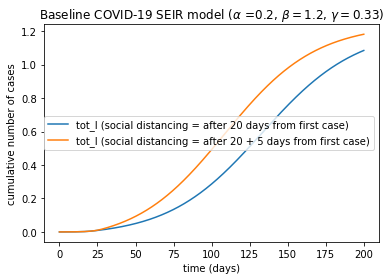

In [151]:
g = plt.figure()

#plt.plot(t,results_base.T[0].T, label="S")
#plt.plot(t,results_base.T[1].T, label="E")
#plt.plot(t,results_base.T[2].T,  label="I")
#plt.plot(t,results_base.T[3].T, label="R")

#plt.plot(t,results_soc_dist.T[1].T,  label="E (social distancing = 0.8)")
#plt.plot(t,results_soc_dist.T[2].T,  label="I (social distancing = 0.8)")

#plt.plot(t,results_soc_dist_2.T[1].T,  label="E (social distancing = 0.5)")
#plt.plot(t,results_soc_dist_2.T[2].T,  label="I (social distancing = 0.5)")


#plt.plot(t,results_soc_dist.T[4].T,  label="tot_I (social distancing = 0.8)")
#plt.plot(t,results_soc_dist_2.T[4].T,  label="tot_I (social distancing = 0.5)")
#plt.plot(t,results_soc_dist_3.T[4].T,  label="tot_I (social distancing = 0.35)")
plt.plot(t,results_soc_dist_4.T[4].T,  label="tot_I (social distancing = after 20 days from first case)")
plt.plot(t,results_soc_dist_5.T[4].T,  label="tot_I (social distancing = after 20 + 5 days from first case)")


plt.legend()
plt.xlabel("time (days)")
#plt.ylabel("population fraction")
plt.ylabel("cumulative number of cases")
plt.title("Baseline COVID-19 SEIR model ($\\alpha$ =0.2, $\\beta=1.2$, $\\gamma=0.33$)")

Text(0.5, 1.0, 'Upgraded COVID-19 SEIR model ($\\alpha$ =0.2, $\\beta=1.2$, $\\gamma=0.33$)')

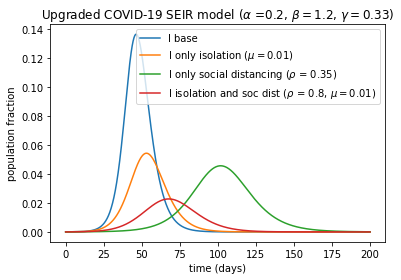

In [162]:
g = plt.figure()

plt.plot(t,results_base.T[2].T,  label="I base")
plt.plot(t,results_removal.T[2].T,  label="I only isolation ($\\mu=0.01$)")
plt.plot(t,results_soc_dist_2.T[2].T,  label="I only social distancing ($\\rho$ = 0.35)")
plt.plot(t,results_removal_and_soc_dist.T[2].T,  label="I isolation and soc dist ($\\rho$ = 0.8, $\\mu=0.01$)")
#plt.plot(t,results_removal.T[4].T)

#plt.plot(results_removal_and_soc_dist.T[3].T+results_removal_and_soc_dist.T[4].T)

plt.legend()

plt.xlabel("time (days)")
plt.ylabel("population fraction")
plt.title("Upgraded COVID-19 SEIR model ($\\alpha$ =0.2, $\\beta=1.2$, $\\gamma=0.33$)")

Find maxima between base, removal and social distancing alone, to show time shift

In [96]:
A = np.array(results_removal.T[2])
maximum_indices_removal = np.where(A==max(results_removal.T[2]))

B = np.array(results_base.T[2])
maximum_indices_base = np.where(B==max(results_base.T[2]))

C = np.array(results_soc_dist_2.T[2])
maximum_indices_cos_dist = np.where(C==max(results_soc_dist_2.T[2]))

print (maximum_indices_base,maximum_indices_removal, maximum_indices_cos_dist)

(array([463]),) (array([531]),) (array([1018]),)


Text(0.5, 1.0, 'Upgraded COVID-19 SEIR model ($\\alpha$ =0.2, $\\beta=1.2$, $\\gamma=0.33$)')

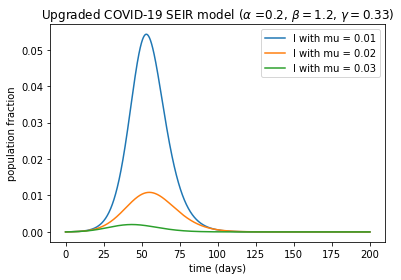

In [101]:
g = plt.figure()

plt.plot(t,results_removal.T[2].T,  label="I with mu = 0.01")
plt.plot(t,results_removal1.T[2].T,  label="I with mu = 0.02")
plt.plot(t,results_removal2.T[2].T,  label="I with mu = 0.03")

plt.legend()

plt.xlabel("time (days)")
plt.ylabel("population fraction")
plt.title("Upgraded COVID-19 SEIR model ($\\alpha$ =0.2, $\\beta=1.2$, $\\gamma=0.33$)")

# debugger

PER OTTENERE L'INTEGRALE DEI BLOCCHI INTERMEDI, DEVO MOLTIPLICARE dt PER IL PARAMETERO DI DESCESCITA (NOORMALIZZAZIONE PER EVITARE RIDONDANZA!!!)

In [143]:
def base_seir_model(init_vals, params, t):
    S_0, E_0, I_0, R_0 = init_vals
    
    S, E, I, R= [S_0], [E_0], [I_0], [R_0]
    alpha, beta, gamma = params
    dt = t[1] - t[0]
    for _ in t[1:]:
        next_S = S[-1] - (beta*S[-1]*I[-1])*dt
        next_E = E[-1] + (beta*S[-1]*I[-1] - alpha*E[-1])*dt
        next_I = I[-1] + (alpha*E[-1] - gamma*I[-1])*dt
        next_R = R[-1] + (gamma*I[-1])*dt
        
        S.append(next_S)
        E.append(next_E)
        I.append(next_I)
        R.append(next_R)
    return np.stack([S, E, I, R]).T

In [136]:
# Define parameters
t_max = 200
dt = .1
t = np.linspace(0, t_max, int(t_max/dt) + 1)

N = 10000
init_vals = 1 - 1/N, 1/N, 0, 0, 0 ,0    #working with fractions of population
alpha = 0.2    # incubation period 5 days
beta = 1.2    # average contact rate [beta = R0*gamma; R0 = 3.5 (Hellewell, 2020); R0 = 3 from GEI]
gamma = 0.33

params = alpha, beta, gamma

#run simulation
results_base = base_seir_model(init_vals[:4], params, t)

0.9713220070088615

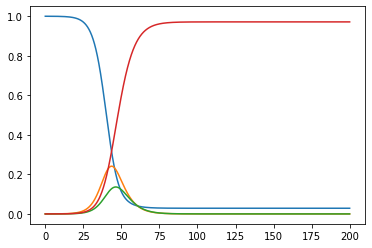

In [147]:
from numpy import trapz

plt.plot(t,results_base)


a=np.cumsum(results_base.T[2])
area = trapz(results_base.T[2], dx=0.1*gamma)   

area
#plt.plot(t,a)

# Plots with Francoise + literature parameters

I go only till I (so no implementing the full model) and I use parameters from literature after checking if they are consistent to Lux ones as estimated by Francoise

In [267]:
# Define parameters
t_max = 200
dt = .1
t = np.linspace(0, t_max, int(t_max/dt) + 1)

N = 10000
init_vals = 1 - 1/N, 1/N, 0, 0, 0 ,0    #working with fractions of population
alpha = 0.2    # incubation period 5 days
beta = 1.46    # average contact rate [beta = R0*gamma; R0 = 3.5 (Hellewell, 2020); R0 = 3 from GEI]
gamma = 0.33   # mean infectious period = 3 following German Epidemiology Institute (GEI) [or = 2 (Peng, 2020) in Wuhan]. gamma=2.8 according to Lux consultants: https://712e30b0-49d2-4397-9c54-243ca09544d9.filesusr.com/ugd/6b8d9d_a9803ce9640240a1bd525965d8d81bde.pdf
rho = [0.8, 0.56, 0.5]   # social distancing (to control contact rate )    #0.56 to get R_0=2.5, as many predictions do
mu = 0.005     # removal rate
mu1 = 0.01
mu2 = 0.03

params = alpha, beta, gamma
params_soc_dist = alpha, beta, gamma, rho[0], rho[0]
params_soc_dist_2 = alpha, beta, gamma, rho[1], rho[1]
params_soc_dist_3 = alpha, beta, gamma, rho[2], rho[2]
params_soc_dist_4 = alpha, beta, gamma, rho[0], rho[2]

params_removal = alpha, beta, gamma, mu
params_removal1 = alpha, beta, gamma, mu1
params_removal2 = alpha, beta, gamma, mu2

params_removal_and_soc_dist = alpha, beta, gamma, mu, rho[1]
params_removal_and_soc_dist2 = alpha, beta, gamma, mu1, rho[1]

# Run simulation
results_base = base_seir_model(init_vals[:4], params, t)
results_soc_dist = seir_model_with_soc_dist(init_vals[:5], params_soc_dist, t)
results_soc_dist_2 = seir_model_with_soc_dist(init_vals[:5], params_soc_dist_2, t)
results_soc_dist_3 = seir_model_with_soc_dist(init_vals[:5], params_soc_dist_3, t)
results_soc_dist_4 = seir_model_with_soc_dist(init_vals[:5], params_soc_dist_4, t)
results_soc_dist_5 = seir_model_with_soc_dist1(init_vals[:5], params_soc_dist_4, t)

results_removal = removal_seir_model(init_vals[:5], params_removal, t)
results_removal1 = removal_seir_model(init_vals[:5], params_removal1, t)
results_removal2 = removal_seir_model(init_vals[:5], params_removal2, t)

results_removal_and_soc_dist = removal_and_social_distancing_seir_model(init_vals[:5], params_removal_and_soc_dist, t)
results_removal_and_soc_dist2 = removal_and_social_distancing_seir_model(init_vals[:5], params_removal_and_soc_dist2, t)

Text(0.5, 1.0, 'Upgraded COVID-19 SEIR model ($\\alpha$ =0.2, $\\beta=1.2$, $\\gamma=0.33$)')

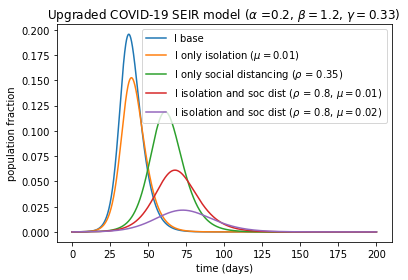

In [268]:
g = plt.figure()

plt.plot(t,results_base.T[2].T,  label="I base")
plt.plot(t,results_removal.T[2].T,  label="I only isolation ($\\mu=0.01$)")
plt.plot(t,results_soc_dist_2.T[2].T,  label="I only social distancing ($\\rho$ = 0.35)")
plt.plot(t,results_removal_and_soc_dist.T[2].T,  label="I isolation and soc dist ($\\rho$ = 0.8, $\\mu=0.01$)")
plt.plot(t,results_removal_and_soc_dist2.T[2].T,  label="I isolation and soc dist ($\\rho$ = 0.8, $\\mu=0.02$)")
#plt.plot(t,results_removal.T[4].T)

#plt.plot(results_removal_and_soc_dist.T[3].T+results_removal_and_soc_dist.T[4].T)

plt.legend()

plt.xlabel("time (days)")
plt.ylabel("population fraction")
plt.title("Upgraded COVID-19 SEIR model ($\\alpha$ =0.2, $\\beta=1.2$, $\\gamma=0.33$)")

Text(0.5, 1.0, 'Evolution of Infected people')

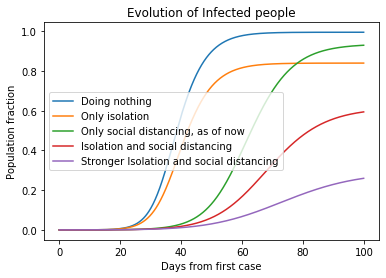

In [269]:
import datetime as date


sum1 = cumsum(results_base.T[2])*gamma*dt
sum2 = cumsum(results_removal.T[2])*gamma*dt
sum3 = cumsum(results_soc_dist_2.T[2])*gamma*dt
sum4 = cumsum(results_removal_and_soc_dist.T[2])*gamma*dt
sum5 = cumsum(results_removal_and_soc_dist2.T[2])*gamma*dt

g = plt.figure()
plot(t[:1000],sum1[:1000],  label="Doing nothing")
plot(t[:1000],sum2[:1000],  label="Only isolation")
plot(t[:1000],sum3[:1000],  label="Only social distancing, as of now")
plot(t[:1000],sum4[:1000],  label="Isolation and social distancing")
plot(t[:1000],sum5[:1000],  label="Stronger Isolation and social distancing")

plt.legend()

plt.xlabel("Days from first case")
plt.ylabel("Population fraction")
plt.title("Evolution of Infected people")

Text(0.5, 1.0, 'Evolution of Infected people')

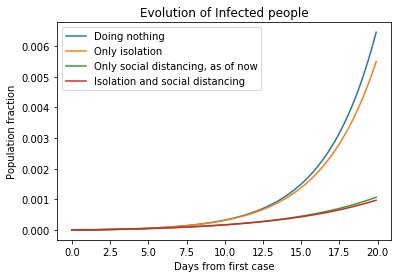

In [270]:
sum1 = cumsum(results_base.T[2])*gamma*dt
sum2 = cumsum(results_removal.T[2])*gamma*dt
sum3 = cumsum(results_soc_dist_2.T[2])*gamma*dt
sum4 = cumsum(results_removal_and_soc_dist.T[2])*gamma*dt

g = plt.figure()
plot(t[:200],sum1[:200],  label="Doing nothing")
plot(t[:200],sum2[:200],  label="Only isolation")
plot(t[:200],sum3[:200],  label="Only social distancing, as of now")
plot(t[:200],sum4[:200],  label="Isolation and social distancing")

plt.legend()

plt.xlabel("Days from first case")
plt.ylabel("Population fraction")
plt.title("Evolution of Infected people")

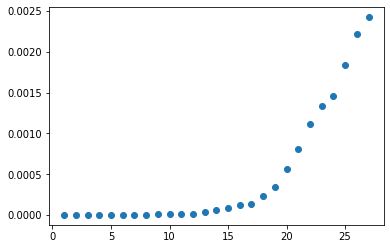

In [424]:
lux_data=[1,1,1,1,1,2,3,4,5,5,7,7,26,34,51,77,81,140,203,335,484,670,798,875,1099,1333,1453]
proportion_lux_data=[]

for i in lux_data:
    proportion_lux_data.append(i/600000)

time_lux_data=np.linspace(1, len(lux_data), len(lux_data))

plot(time_lux_data,proportion_lux_data,'o')

Text(0.5, 1.0, 'Evolution of Infected people')

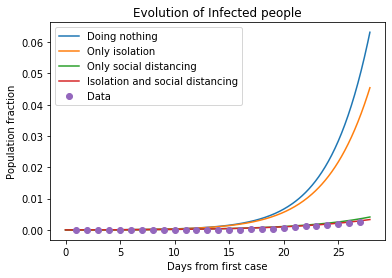

In [428]:
# Join graphs

days_to_now = 280

g = plt.figure()
plot(t[:days_to_now],sum1[:days_to_now],  label="Doing nothing")
plot(t[:days_to_now],sum2[:days_to_now],  label="Only isolation")
plot(t[:days_to_now],sum3[:days_to_now],  label="Only social distancing")
plot(t[:days_to_now],sum4[:days_to_now],  label="Isolation and social distancing")
plot(time_lux_data,proportion_lux_data,'o',  label="Data")

plt.legend()

plt.xlabel("Days from first case")
plt.ylabel("Population fraction")
plt.title("Evolution of Infected people")                                                                                  

In [303]:
# to get the total number in infected, with strict measures (bit milder than in China)

print(sum5[600]*600000)

40494.87957604042


In [295]:
# Numbers of today: (real number 1099)

sum3[230]*600000

1089.4642992459808

In [304]:
# forecast for tomorrow (24/03/2020)
# wait for Francoise model too

print(sum3[250]*600000)
print(sum4[240]*600000)

1525.981507406525
1107.4491610983055


This means that around 66.000 people will get critically infectious, leading to about 660 deaths if we consider 1% death rate. But we're probably already past that.  
It's anyway consisistent with predictions from Vasja Savic of the taskforce group (maybe he's even underestimating): I also checked what Vasja Sivec just sent (his code and results [../covid-19_rapid/Results_3_24_2020]). The prediction is consistent provided that we implement strict measures as in Korea or Hubei. What my model shows in addition is that, right now, we cannot differentiate between social distancing alone and with isolation. This means his prediction can underestimate a lot if politicians don’t enforce the measures soon

Text(0.5, 1.0, 'Protected')

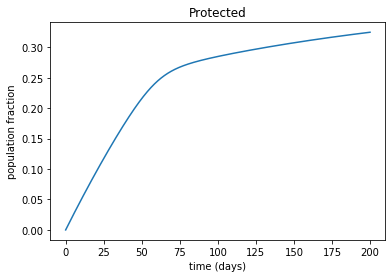

In [274]:
# this to control we don't really need to remove 100% of the initial population to achieve suppression

plt.plot(t,results_removal_and_soc_dist.T[4])
xlabel("time (days)")
ylabel("population fraction")
title("Protected")

In fact, the total number of protected is around 40-50% of the population, which is realistic

# Estimating the effect of removing Exposed that had been identified

In [493]:
def removal_and_social_distancing_seir_model(init_vals, params, t):
    S_0, E_0, I_0, R_0, P_0 = init_vals
    S, E, I, R, P = [S_0], [E_0], [I_0], [R_0], [P_0]
    alpha, beta, gamma, mu, rho = params
    dt = t[1] - t[0]
    for _ in t[1:]:
        next_S = S[-1] - (rho*beta*S[-1]*I[-1] + mu*S[-1])*dt
        next_E = E[-1] + (rho*beta*S[-1]*I[-1] - alpha*E[-1])*dt
        next_I = I[-1] + (alpha*E[-1] - gamma*I[-1])*dt
        next_R = R[-1] + (gamma*I[-1])*dt
        next_P = P[-1] + (mu*S[-1])*dt
        S.append(next_S)
        E.append(next_E)
        I.append(next_I)
        R.append(next_R)
        P.append(next_P)
    return np.stack([S, E, I, R, P]).T

def identify_and_remove_asymptomatic_seir_model(init_vals, params, t):
    S_0, E_0, I_0, R_0, P_0 = init_vals
    S, E, I, R, P = [S_0], [E_0], [I_0], [R_0], [P_0]
    alpha, beta, gamma, mu, rho, x, y = params
    dt = t[1] - t[0]
    for _ in t[1:]:
        next_S = S[-1] - (rho*beta*S[-1]*I[-1] + mu*S[-1])*dt
        
        if len(E)<300:
            next_E = E[-1] + (rho*beta*S[-1]*I[-1] - alpha*E[-1])*dt
        else: 
            next_E = E[-1] + (rho*beta*S[-1]*I[-1] - (1-x*y)*alpha*E[-1] - y*x*0.33*E[-1])*dt  #3 days to get reliable results from PCR
            
        next_I = I[-1] + (alpha*E[-1] - gamma*I[-1])*dt
        next_R = R[-1] + (gamma*I[-1])*dt
        next_P = P[-1] + (mu*S[-1])*dt
        S.append(next_S)
        E.append(next_E)
        I.append(next_I)
        R.append(next_R)
        P.append(next_P)
    return np.stack([S, E, I, R, P]).T

In [510]:
# Define parameters
t_max = 200
dt = .1
t = np.linspace(0, t_max, int(t_max/dt) + 1)

N = 10000
init_vals = 1 - 1/N, 1/N, 0, 0, 0 ,0    #working with fractions of population
alpha = 0.2    # incubation period 5 days
beta = 1.46 #1.2    # average contact rate [beta = R0*gamma; R0 = 3.5 (Hellewell, 2020); R0 = 3 from GEI]
gamma = 0.33   # mean infectious period = 3 following German Epidemiology Institute (GEI) [or = 2 (Peng, 2020) in Wuhan]. gamma=2.8 according to Lux consultants: https://712e30b0-49d2-4397-9c54-243ca09544d9.filesusr.com/ugd/6b8d9d_a9803ce9640240a1bd525965d8d81bde.pdf
rho = 0.56 #0.7   # social distancing (to control contact rate )    #0.56 to get R_0=2.5, as many predictions do
mu = 0.001     # removal rate
ics = np.linspace(0, 1, 100)    #percentage of asymptomatic correctly identified and removed (detection accuracy)
ypsilon = np.linspace(0, 1, 100) #sensitivity of the tests to get asymptomatic (testing accuracy)

#maximus=np.zeros([10,10])
maximi=np.zeros([100,100])
maximum_indices = []

params_removal_and_soc_dist = alpha, beta, gamma, mu, rho
params_removal_and_soc_dist2 = alpha, beta, gamma, mu, rho

#params_identify_exposed1 = alpha, beta, gamma, mu, rho, ics, ypsilon


# Run simulation

results_removal_and_soc_dist = removal_and_social_distancing_seir_model(init_vals[:5], params_removal_and_soc_dist, t)
results_removal_and_soc_dist2 = removal_and_social_distancing_seir_model(init_vals[:5], params_removal_and_soc_dist2, t)



In [511]:
for n in range(len(ics)):
    for m in range(len(ypsilon)):
        params_identify_exposed = alpha, beta, gamma, mu, rho, ics[n], ypsilon[m]
    
        results_identify_exposed = identify_and_remove_asymptomatic_seir_model(init_vals[:5], params_identify_exposed, t)
        #maximus.append(max(results_identify_exposed.T[2]))
        maximi[n,m]=max(results_identify_exposed.T[2])
        #maximum_indices.append(np.where(results_identify_exposed.T[2]==max(results_identify_exposed.T[2])))

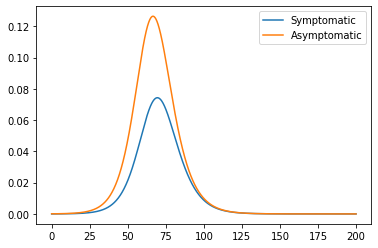

In [431]:
plt.figure()

plt.plot(t,results_removal_and_soc_dist.T[2], label="Symptomatic")
plt.plot(t,results_removal_and_soc_dist.T[1], label="Asymptomatic")

plt.legend()

In [432]:
ratio = []
sum_a = cumsum(results_removal_and_soc_dist.T[2])*dt
sum_b = cumsum(results_removal_and_soc_dist.T[1])*dt

for i in range(len(sum_a)):
               ratio.append(sum_a[i]/sum_b[i])
       

Text(0, 0.5, 'Ratio')

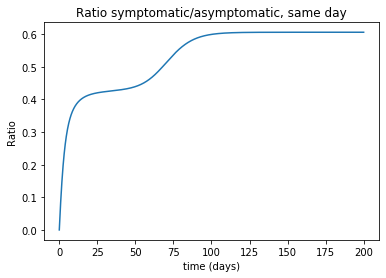

In [433]:
plt.plot(t,ratio)
plt.title("Ratio symptomatic/asymptomatic, same day")
xlabel("time (days)")
ylabel("Ratio")

Text(0, 0.5, 'Population fraction, per day')

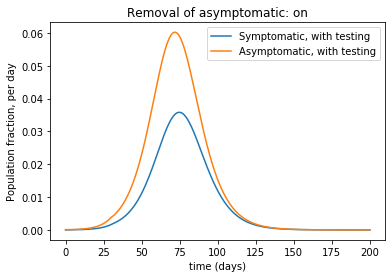

In [434]:
plt.figure()

plt.plot(t,results_identify_exposed.T[2], label="Symptomatic, with testing")
plt.plot(t,results_identify_exposed.T[1], label="Asymptomatic, with testing")
#plt.plot(t,results_removal_and_soc_dist.T[2], label="Symptomatic, No testing")

plt.legend()

plt.title("Removal of asymptomatic: on")
xlabel("time (days)")
ylabel("Population fraction, per day")

In [435]:
1500/600000

0.0025

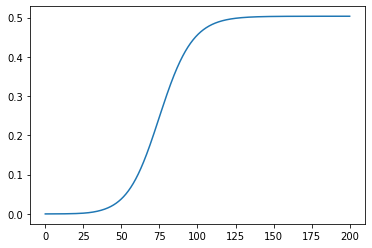

In [436]:
sum_c = cumsum(results_identify_exposed.T[2])*dt*gamma

plot(t,sum_c)

Text(0, 0.5, 'Peak of daily infectious')

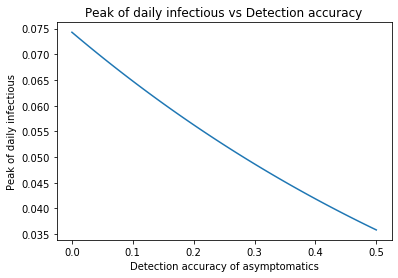

In [437]:
plot(ics,maximums)

plt.title("Peak of daily infectious vs Detection accuracy")
xlabel("Detection accuracy of asymptomatics")
ylabel("Peak of daily infectious")

ValueError: x and y can be no greater than 2-D, but have shapes (100,) and (100, 1, 1)

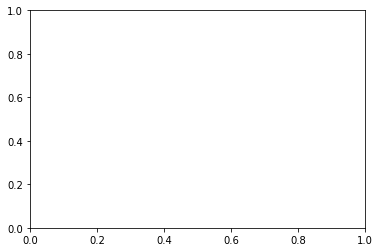

In [440]:
plot(ics,maximum_indices)

plt.title("Peak of daily infectious vs Detection accuracy")
xlabel("Detection accuracy of asymptomatics")
ylabel("Peak of daily infectious")

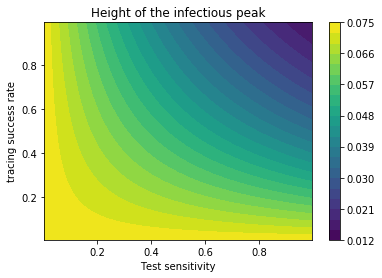

In [517]:
import matplotlib.pyplot as pylt

fig, ax = plt.subplots()

plt.contourf(maximi,20, cmap='viridis',extent=[0,1,0,1],origin="lower")
plt.colorbar()


plt.xlabel('Test sensitivity') #corresponds to ypsilon
plt.ylabel('tracing success rate') #corresponds to ics
#plt.xlabel("Test accuracy")    
#plt.ylabel("Detection accuracy")    
plt.title("Height of the infectious peak")

plt.show()